<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/close_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Small python script that plots the difference between close and open prices of s&p stocks

In [ ]:
# Installation
!pip install --upgrade mxnet==1.6.0
!pip install gluonts
!pip install yfinance
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install torch
!pip install evaluate
!pip install torchviz
!pip install jupyter-dash
!pip install sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

In [ ]:

## Hyper parameters
buy_trigger = 3             # times standard deviation
sell_trigger = 1            # times the avg cost of the security to grow before we sell
security_age = 15           # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000  # times the orignal amount to grow before we lockin the gains.
mean_type = "+ve"           # only consider stocks with +ve mean of ND. These stocks have been growing over the period of time
max_stocks_to_buy = 5       # number of stocks to buy at buy trigger. We can change this value to be more adaptive based on market cap of the security and other parameters.
backtest_iterations = 100    # number of backtests to run


original_balance = 10000    # seed money to start investing
current_account = original_balance
portfolio = {}

In [ ]:
import yfinance as yahooFinance
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np

stocks1 = ["AAPL", 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'UNH', 'XOM', 'JNJ', 'V', 'JPM', 'NVDA']
stocks = ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'UNH', 'XOM', 'JNJ', 'V', 'JPM', 'NVDA',
          'WMT', 'TSLA', 'PG', 'META', 'MA', 'CVX', 'LLY', 'HD', 'ABBV', 'MRK', 'BAC', 'KO', 
          'PFE', 'PEP', 'AVGO', 'ORCL', 'TMO', 'COST', 'CSCO', 'ABT', 'MCD', 'NKE', 'DHR', 
          'TMUS', 'ACN', 'DIS', 'VZ', 'NEE', 'CMCSA', 'WFC', 'TXN', 'LIN', 'PM', 'UPS', 'ADBE', 
          'BMY', 'SCHW', 'MS', 'CRM', 'COP', 'RTX', 'AMGN', 'NFLX', 'HON', 'T', 'UNP', 'QCOM', 
          'IBM', 'DE', 'CAT', 'LOW', 'BA', 'SBUX', 'INTC', 'SPGI', 'LMT', 'GS', 'CVS', 'BLK', 
          'AXP', 'ELV', 'AMD', 'GILD', 'INTU', 'PLD', 'MDT', 'AMT', 'ADP', 'SYK', 'ISRG', 
          'TJX', 'EL', 'C', 'CB', 'CI', 'MDLZ', 'AMAT', 'PYPL', 'ADI', 'BKNG', 'MMC', 'MO', 'GE', 
          'DUK', 'SLB', 'SO', 'PGR', 'NOW', 'NOC', 'VRTX', 'EOG', 'REGN', 'ZTS', 'TGT', 'MRNA', 'BDX', 
          'MMM', 'HCA', 'USB', 'ITW', 'APD', 'CSX', 'GD', 'PNC', 'BSX', 'CL', 'WM', 'EQIX', 'FISV', 'FCX', 
          'CME', 'ETN', 'CCI', 'AON', 'SHW', 'LRCX', 'MU', 'TFC', 'HUM', 'ATVI', 'ICE', 'KLAC', 'NSC', 
          'CHTR', 'OXY', 'EMR', 'MET', 'PXD', 'MPC', 'MCO', 'MCK', 'DG', 'MNST', 'KHC', 'ORLY', 
          'D', 'VLO', 'SNPS', 'SRE', 'F', 'KDP', 'AEP', 'GIS', 'PSA', 'MAR', 'PSX', 'ROP', 'FDX', 'EW', 
          'ADM', 'APH', 'AIG', 'JCI', 'HSY', 'A', 'KMB', 'AZO', 'CTAS', 'CDNS', 'TRV', 'AFL', 'HES', 'CTVA', 
          'MSI', 'EXC', 'ECL', 'CNC', 'NXPI', 'DXCM', 'PAYX', 'NEM', 'KMI', 'ADSK', 'TT', 'MCHP', 'DVN', 
          'ROST', 'LVS', 'FIS', 'AJG', 'STZ', 'BIIB', 'SYY', 'CMG', 'O', 'RSG', 'IQV', 'PH', 'XEL', 'DOW', 
          'SPG', 'WMB', 'TEL', 'MSCI', 'IDXX', 'BK', 'NUE', 'LHX', 'FTNT', 'COF', 'ALL', 'HAL', 'PRU', 'CARR', 
          'DD', 'TDG', 'YUM', 'ANET', 'HLT', 'PCAR', 'CMI', 'ED', 'ABC', 'EA', 'AMP', 'OTIS', 'WELL', 'MTD', 
          'ODFL', 'SBAC', 'KR', 'AME', 'DLTR', 'VICI', 'DHI', 'ROK', 'WBA', 'KEYS', 'PEG', 'PCG', 'CSGP', 
          'CTSH', 'ENPH', 'RMD', 'OKE', 'WEC', 'BKR', 'NDAQ', 'WBD', 'ILMN', 'PPG', 'GLW', 'STT', 'LYB', 
          'ES', 'IFF', 'DLR', 'AWK', 'VRSK', 'DFS', 'HPQ', 'GWW', 'GPN', 'WTW', 'ON', 'FAST', 'LEN', 'CEG', 
          'APTV', 'TROW', 'URI', 'IT', 'ALB', 'CBRE', 'ZBH', 'EIX', 'MTB', 'CDW', 'ULTA', 'EFX', 'HRL', 'FANG', 
          'TSCO', 'EBAY', 'DAL', 'FE', 'VMC', 'HIG', 'ARE', 'K', 'RJF', 'GPC', 'TSN', 'FITB', 'WY', 'FTV', 
          'ACGL', 'DTE', 'BAX', 'AEE', 'IR', 'AVB', 'FRC', 'MKC', 'VRSN', 'PPL', 'EQR', 'ETR', 'HPE', 'LH', 
          'ANSS', 'LUV', 'PFG', 'MLM', 'HBAN', 'XYL', 'RF', 'CAH', 'WAT', 'CFG', 'STE', 'PWR', 'CHD', 'HOLX', 
          'CTRA', 'NTRS', 'VTR', 'EXR', 'DOV', 'CAG', 'CNP', 'WRB', 'TDY', 'GRMN', 'CMS', 'EPAM', 'STLD', 'BBY', 
          'WST', 'WAB', 'DRI', 'FSLR', 'INVH', 'MPWR', 'AES', 'JBHT', 'ALGN', 'AMCR', 'ROL', 'PAYC', 'MAA', 'IEX', 
          'INCY', 'TTWO', 'BALL', 'OMC', 'CLX', 'DGX', 'CINF', 'EXPD', 'MRO', 'MOH', 'KEY', 'COO', 'BRO', 'TRGP', 
          'SEDG', 'FOX', 'FOXA', 'PKI', 'SJM', 'HWM', 'CPB', 'LYV', 'BR', 'CF', 'FMC', 'J', 'ATO', 'ETSY', 'FDS', 
          'SWKS', 'UAL', 'ZBRA', 'NVR', 'AVY', 'MOS', 'PTC', 'RCL', 'LKQ', 'MGM', 'SYF', 'TXT', 'TER', 
          'EVRG', 'CPRT', 'BEN', 'IRM', 'VTRS', 'EXPE', 'FLT', 'LW', 'GEN', 'PEAK', 'L', 'KIM', 'APA', 'IPG', 
          'ESS', 'NTAP', 'RE', 'NDSN', 'LNT', 'AKAM', 'LDOS', 'IP', 'TYL', 'TRMB', 'SNA', 'UDR', 'PARA', 'JKHY', 
          'CBOE', 'CE', 'BIO', 'POOL', 'MTCH', 'EQT', 'SWK', 'PKG', 'WDC', 'TFX', 'MKTX', 'CPT', 'DPZ', 'CRL', 'GL', 
          'STX', 'HST', 'VFC', 'MAS', 'NWS', 'NWSA', 'NI', 'PHM', 'CHRW', 'WYNN', 'HSIC', 'CCL', 'EMN', 'KMX', 'REG', 
          'BXP', 'UHS', 'BBWI', 'JNPR', 'TPR', 'BWA', 'AAL', 'ALLE', 'QRVO', 'CZR', 'CDAY', 'WRK', 'AOS', 'AAP', 'HII', 
          'HAS', 'IVZ', 'CMA', 'FFIV', 'CTLT', 'PNW', 'WHR', 'FRT', 'RHI', 'PNR', 'DISH', 'SEE', 'RL', 'ZION', 'OGN', 
          'NRG', 'XRAY', 'MHK', 'DVA', 'GNRC', 'AIZ', 'DXC', 'NWL', 'ALK', 'NCLH', 'LUMN', 'LNC', 'VNO', 'TECH', 
          'TAP',] # '^IXIC', '^GSPC', '^DJI']

stocks_ts = pd.DataFrame()
stocks_spread = pd.DataFrame()

for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period="3y")
    data.drop(data.tail(1).index,inplace=True)
    d = data.copy()[['Open', 'Close']]
    stocks_ts[stock+"_Open"] = d['Open']
    stocks_ts[stock+"_Close"] = d['Close']
    stocks_spread[stock+"_Diff"] = d['Close'] - d['Open']

    stocks_ts = stocks_ts.copy()
    stocks_spread = stocks_spread.copy()
    #latest[stock+"_Diff"] = data.iloc[-1]['Close'] - data.iloc[-1]['Open']
    """
    fig = go.Figure(data=[go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['Open'],
                low=d['Close'],
                close=d['Close'])])
    fig.update_layout(
      title=stock,
      yaxis_title=stock +' Stock',
      shapes = [dict(
          x0='2022-12-09', x1='2022-12-09', y0=0, y1=1, xref='x', yref='paper',
          line_width=2)],
      annotations=[dict(
          x='2022-12-09', y=0.05, xref='x', yref='paper',
          showarrow=False, xanchor='left', text='Increase Period Begins')]
    )

    fig.show()

    stocks_spread['Date'] = stocks_spread.index
    fig = px.line(stocks_spread, x="Date", y=stock+"_Diff", title=stock + " Price change", markers=True) 
    fig.show()

    x = pd.Series(stocks_spread[stock+"_Diff"])
    ax = x.plot.kde(figsize=(30,8))
    #sns.set(rc={'figure.figsize':(25.7,8.27)})
    #sns.lineplot(x="Date",y=stock+"_Diff", data=stocks_spread, markers=True, err_style="bars")
    #sns.despine();
    """

In [ ]:
#print(stocks_spread.describe())
std = stocks_spread.describe().loc['std']
mean = stocks_spread.describe().loc['mean']
std = pd.DataFrame.from_dict(std)
std.columns = ['std',]

mean = pd.DataFrame.from_dict(mean)
mean.columns = ['mean',]

fig = px.line(std, title=stock + " Price change", markers=True) 
fig.show()

In [ ]:
# Determine what stocks are in buy zone and what stocks are in sell zone
# Start date of the investing

def getsellbuy(index, portfolio):
  latest = {}
  for s in stocks:
      latest[s + "_Diff"] = stocks_ts.loc[index][s+"_Close"] - stocks_ts.loc[index][s+"_Open"]

  latest = pd.Series(latest)
  pd.DataFrame.from_dict(latest)
  latest_diff = pd.DataFrame.from_dict(latest)
  latest_diff.columns = ['diff',]
  #latest_diff = latest_diff.iloc[::-1]

  latest_diff['std'] = std['std']

  # Find stocks that are in buy range
  latest_diff['buy'] = np.where(((mean['mean'] > 0) & (latest_diff['diff'] < 0) & (latest_diff['diff'] < -buy_trigger * std['std'])), True, False)

  # Find stocks that are in sell range
  latest_diff['sell'] = False #np.where((latest_diff['diff'] >= std['std']), True, False)
  for s in stocks:
    if s in portfolio:
      t = index - portfolio[s]['date']
      avg = sum(portfolio[s]['costs'])/len(portfolio[s]['costs'])
      if avg + sell_trigger * std['std'][s+"_Diff"] <= stocks_ts.loc[index, s+"_Close"]:
        # If the avg cost of the security has grown more than std
        #print(s, avg, portfolio[s]['costs'], std['std'][s+"_Diff"], stocks_ts.loc[index, s+"_Close"])
        latest_diff.at[s+"_Diff", 'sell'] = True
      elif t.days > security_age:
        # if the security has aged for certain days, cut the losses
        latest_diff.at[s+"_Diff", 'sell'] = True
  
  # Print which stocks are buy and which are sell
  #print("Stock to Buy on " + str(index))
  #print(latest_diff[latest_diff['buy']])
  #print()
  #print("Stocks to Sell on " + str(index))
  #print(latest_diff[latest_diff['sell']])
  
  return latest_diff[latest_diff['sell']], latest_diff[latest_diff['buy']]


In [ ]:
# We assume that we invest $100 in each stock that is in the buy zone
# and sell all stocks in the sell zone

# We will start back testing from year back. We can always change the starting point and tune the model.

def calculate_networth(backtest_start_date):
  networth = current_account
  for stock, value in portfolio.items():
    networth += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
  return networth

def do_one_backtesting(tradingdays_togoback):
  global portfolio
  global original_balance
  global current_account

  original_balance = 10000
  current_account = original_balance
  portfolio = {}

  idx = int(len(stocks_ts.index)- tradingdays_togoback)
  price_movement = []
  for backtest_start_date in stocks_ts.index[idx:]:
      sell, buy = getsellbuy(backtest_start_date, portfolio)

      # process the stocks that are marked sell
      for st in sell.iterrows():
        stock = st[0].split('_')[0]
        if stock in portfolio:
          current_account += portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio.pop(stock)
      
      # buy stocks that are marked by. We are buying max_stocks_to_buy number of stocks
      # TODO: The number of stocks to be must be adaptive. Will come up with some
      # algorithm based on:
      # 1. Market capitalization
      # 2. volatility
      # and other criteria
      # The goal is to put the money to work
      for st in buy.iterrows():
        stock = st[0].split('_')[0]
        if current_account > max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]:
          current_account -= max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          if not stock in portfolio:
              assert portfolio.get(stock, None) == None
              portfolio[stock] = {'shares': 0, 'costs':[], 'date': backtest_start_date}
          portfolio[stock]['shares'] += max_stocks_to_buy
          for i in range(portfolio[stock]['shares']):
            portfolio[stock]['costs'].append(stocks_ts.loc[backtest_start_date][stock+"_Close"])

      # lock in the gains after 10% increase of networth
      nw = calculate_networth(backtest_start_date)
      price_movement.append(nw)
      if nw > original_balance * lockin_gains_factor:
          #print(backtest_start_date, calculate_networth(backtest_start_date), current_account, portfolio)
          for stock, value in portfolio.items():
            current_account += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio = {}
          original_balance = current_account
          #print(current_account, portfolio)
      #print(current_account, portfolio)
  return calculate_networth(backtest_start_date), current_account, price_movement

Total networth: 10382 (Cash 8360) after going back 153
Total networth: 11600 (Cash 9334) after going back 117
Total networth: 11629 (Cash 9362) after going back 211
Total networth: 10866 (Cash 8599) after going back 265
Total networth: 11261 (Cash 9086) after going back 218
Total networth: 11629 (Cash 9362) after going back 211
Total networth: 12270 (Cash 10095) after going back 192
Total networth: 11165 (Cash 9142) after going back 145
Total networth: 10781 (Cash 8606) after going back 133
Total networth: 11478 (Cash 9211) after going back 115
Total networth: 11993 (Cash 9726) after going back 189
Total networth: 11593 (Cash 9326) after going back 230
Total networth: 10772 (Cash 8658) after going back 138
Total networth: 10866 (Cash 8599) after going back 265
Total networth: 10676 (Cash 8409) after going back 103
Total networth: 10772 (Cash 8658) after going back 139
Total networth: 11190 (Cash 9015) after going back 113
Total networth: 11275 (Cash 9008) after going back 243
Total net

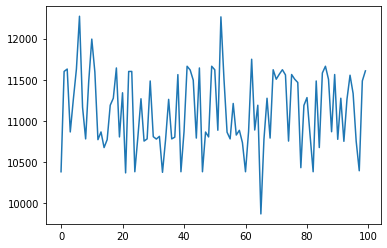

11123.820547246933


In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 15  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  original_balance = 10000
  current_account = original_balance
  portfolio = {}
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  #print(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

Total networth: 10531 (Cash 8509) after going back 281
Total networth: 11194 (Cash 9018) after going back 109
Total networth: 11252 (Cash 9077) after going back 110
Total networth: 10767 (Cash 9060) after going back 158
Total networth: 10684 (Cash 8661) after going back 289
Total networth: 12389 (Cash 10213) after going back 175
Total networth: 10662 (Cash 8395) after going back 146
Total networth: 12317 (Cash 10294) after going back 127
Total networth: 11494 (Cash 9227) after going back 268
Total networth: 10671 (Cash 8405) after going back 151
Total networth: 11527 (Cash 9414) after going back 243
Total networth: 12389 (Cash 10213) after going back 175
Total networth: 11505 (Cash 9482) after going back 171
Total networth: 10680 (Cash 8413) after going back 283
Total networth: 12101 (Cash 10079) after going back 213
Total networth: 11543 (Cash 9430) after going back 119
Total networth: 11505 (Cash 9238) after going back 164
Total networth: 12713 (Cash 10447) after going back 192
Total

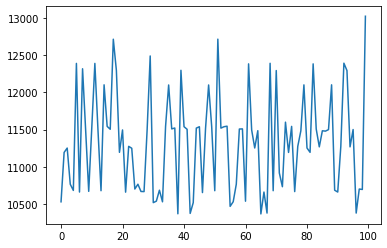

11326.501135921479


In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 15  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  #print(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

Total networth: 13303 (Cash 372) after going back 223
Total networth: 11154 (Cash 269) after going back 134
Total networth: 12078 (Cash 365) after going back 125
Total networth: 12225 (Cash 1608) after going back 213
Total networth: 11522 (Cash 329) after going back 278
Total networth: 12443 (Cash 549) after going back 193
Total networth: 12078 (Cash 365) after going back 125
Total networth: 11221 (Cash 310) after going back 165
Total networth: 11051 (Cash 256) after going back 171
Total networth: 11805 (Cash 537) after going back 186
Total networth: 11250 (Cash 981) after going back 253
Total networth: 10420 (Cash 1274) after going back 284
Total networth: 11000 (Cash 266) after going back 230
Total networth: 12225 (Cash 1609) after going back 200
Total networth: 12027 (Cash 1342) after going back 218
Total networth: 11196 (Cash 275) after going back 245
Total networth: 10962 (Cash 256) after going back 136
Total networth: 11196 (Cash 275) after going back 246
Total networth: 10420 (C

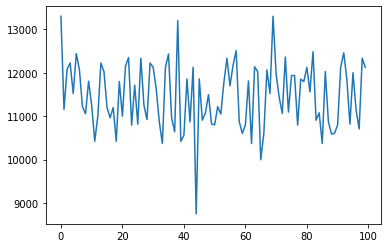

11469.198366880417


In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 1000  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  #print(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

Total networth: 11236 (Cash 967) after going back 146
Total networth: 12510 (Cash 373) after going back 130
Total networth: 12091 (Cash 354) after going back 210
Total networth: 11797 (Cash 516) after going back 185
Total networth: 11012 (Cash 278) after going back 229
Total networth: 11012 (Cash 278) after going back 229
Total networth: 10693 (Cash 27) after going back 243
Total networth: 10601 (Cash 1177) after going back 250
Total networth: 12380 (Cash 308) after going back 194
Total networth: 10816 (Cash 503) after going back 159
Total networth: 11858 (Cash 661) after going back 176
Total networth: 11154 (Cash 269) after going back 134
Total networth: 10799 (Cash 1232) after going back 251
Total networth: 11046 (Cash 272) after going back 174
Total networth: 11066 (Cash 247) after going back 141
Total networth: 11805 (Cash 656) after going back 198
Total networth: 11211 (Cash 1033) after going back 166
Total networth: 10030 (Cash 504) after going back 297
Total networth: 10704 (Cas

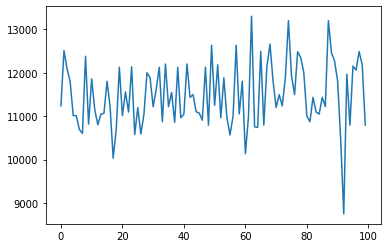

11475.193818426133


In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 1000  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  #print(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))